# Import & Config

In [1]:
!pip install hazm

In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable # This package has predefined gradient and derivative functions

import string
import re

In [3]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if train_on_gpu else 'cpu')

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
#-------------------------------------------------------------------#

## Download dataset from Kaggle

In [6]:
!pip install kaggle

In [7]:
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download miladfa7/persian-wikipedia-dataset -f Persian-WikiText-1.txt

cp: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/miladfa7/persian-wikipedia-dataset
License(s): CC0-1.0
100% 27.5M/27.5M [00:02<00:00, 21.7MB/s]
100% 27.5M/27.5M [00:02<00:00, 11.7MB/s]


In [8]:
!kaggle datasets download miladfa7/persian-wikipedia-dataset -f Persian-WikiText-1.txt

Dataset URL: https://www.kaggle.com/datasets/miladfa7/persian-wikipedia-dataset
License(s): CC0-1.0
Persian-WikiText-1.txt.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!kaggle datasets download alioraji/persian-stop-words -f Persian_Stop_Words.txt

Dataset URL: https://www.kaggle.com/datasets/alioraji/persian-stop-words
License(s): other
  0% 0.00/45.5k [00:00<?, ?B/s]
100% 45.5k/45.5k [00:00<00:00, 1.02MB/s]


In [10]:
!unzip Persian-WikiText-1.txt.zip

Archive:  Persian-WikiText-1.txt.zip
  inflating: Persian-WikiText-1.txt  


## Data Preprocessing

In [11]:

wiki_file_path = "Persian-WikiText-1.txt"

with open(wiki_file_path, 'r', encoding='utf-8') as file:
    persian_text = file.read()


import re
def clean_text(text):

    text = re.sub(r'[^\w\s،؟!.]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


cleaned_text = clean_text(persian_text)

print("Sample cleaned text:", cleaned_text[:500])

# Tokenization using Byte-Pair Encoding (BPE)
from tokenizers import Tokenizer, models, trainers, pre_tokenizers


tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()


trainer = trainers.BpeTrainer(vocab_size=30000, special_tokens=["<unk>", "<pad>", "<s>", "</s>"])


from tokenizers.processors import TemplateProcessing

with open("cleaned_text.txt", "w", encoding="utf-8") as file:
    file.write(cleaned_text)

tokenizer.train(["cleaned_text.txt"], trainer)

tokenizer.post_processor = TemplateProcessing(
    single="<s> $A </s>",
    pair="<s> $A </s> </s> $B </s>",
    special_tokens=[
        ("<s>", tokenizer.token_to_id("<s>")),
        ("</s>", tokenizer.token_to_id("</s>")),
    ],
)

tokenizer.save("persian_tokenizer.json")

example_text = "این یک مثال ساده برای توکنایز کردن است."
encoded = tokenizer.encode(example_text)

print("Tokens:", encoded.tokens)
print("IDs:", encoded.ids)


Sample cleaned text: عنوان مقاله صفحه اصلی templatestyles srcصفحه اصلی عنوان مقاله ویکی پدیا ویکی پدیا کوته نوشت به صورت وپ و WP یک دانشنامه برخط چندزبانه مبتنی بر وب با محتوای آزاد و همکاری باز است که با همکاری افراد داوطلب نوشته می شود و هر کسی که به اینترنت و وب دسترسی داشته باشد می تواند مقالات آن را ببیند و ویرایش کند. نام ویکی پدیا واژه ای ترکیبی است که از واژه های ویکی وبگاه مشارکتی و انسایکلوپدیا Encyclopedia دانشنامه یا دائرةالمعارف گرفته شده است. هدف ویکی پدیا آفرینش و انتشار جهانی یک دانشنامه با محتوای آز
Tokens: ['<s>', 'این', 'یک', 'مثال', 'ساده', 'برای', 'توکن', 'ایز', 'کردن', 'است', '.', '</s>']
IDs: [2, 1372, 1390, 2690, 3080, 1421, 27971, 4527, 1912, 1362, 5, 3]


. کیفیت داده‌های ورودی مدل:

داده‌های خام معمولاً شامل نویز (مانند کاراکترهای غیرضروری، فاصله‌های اضافی، یا کلمات غیرمرتبط) است. وجود نویز در داده‌ها می‌تواند به مشکلات زیر منجر شود:

    کاهش دقت مدل.
    افزایش زمان آموزش، زیرا مدل باید نویز را نیز پردازش کند.
    یادگیری الگوهای نادرست از داده‌ها.

به همین دلیل، حذف نویز و تمیز کردن داده‌ها تضمین می‌کند که مدل تنها اطلاعات مرتبط و مهم را پردازش می‌کند.
2. کاهش پیچیدگی محاسباتی:

    داده‌های تمیز و پیش‌پردازش‌شده اندازه‌ی کوچک‌تر و کارآمدتری دارند.
    این امر باعث کاهش مصرف حافظه و زمان پردازش می‌شود و آموزش مدل سریع‌تر و بهینه‌تر انجام می‌گیرد.

3. تناسب داده‌ها با مدل:

مدل‌های زبانی مانند RNN برای پردازش داده‌های ساختاریافته و استاندارد طراحی شده‌اند. اگر داده‌ها شامل کاراکترهای خاص یا قالب‌های نامتعارف باشند، ممکن است مدل نتواند آن‌ها را به درستی تفسیر کند. بنابراین، تبدیل داده‌ها به فرمت مناسب (مانند توکنایز کردن) برای بهبود عملکرد مدل ضروری است.
4. اثرگذاری نویز بر پیش‌بینی مدل:

    اگر نویز در داده باقی بماند، مدل ممکن است آن را به‌عنوان الگوهای معنی‌دار یاد بگیرد.
    این موضوع باعث می‌شود خروجی مدل قابل اطمینان نباشد و مدل به جای یادگیری مفاهیم مهم، روی جزئیات غیرضروری متمرکز شود.

### *Byte Pair Encoding (BPE)**

یک تکنیک برای توکنایز کردن متن است که کاراکترها و زیرواژه‌ها را برای کاهش اندازه داده‌ها ترکیب می‌کند.  

---

### **مراحل عملکرد:**
1. **شروع با کاراکترهای منفرد:** متن به کوچک‌ترین واحدها (کاراکترها) شکسته می‌شود.
2. **ادغام جفت‌های پرتکرار:** جفت‌هایی که بیشترین تکرار دارند، به توکن‌های جدید تبدیل می‌شوند.
3. **تکرار فرآیند:** ادغام‌ها ادامه پیدا می‌کنند تا تعداد مشخصی از توکن‌ها ساخته شود.
4. **ساخت دیکشنری:** لیستی از توکن‌های پرتکرار ایجاد می‌شود که برای توکنایز کردن متن‌های جدید استفاده می‌شود.

---

### **مزایا:**
- **مدیریت کلمات ناشناخته:** کلمات جدید به زیرواژه‌ها شکسته می‌شوند.
- **کاهش طول داده‌ها:** کلمات پرتکرار به توکن‌های واحد تبدیل می‌شوند.
- **انعطاف‌پذیری:** در زبان‌های پیچیده مانند فارسی به‌خوبی کار می‌کند.

### **معایب:**
- **پیچیدگی زمانی:** یادگیری دیکشنری زمان‌بر است.
- **شکستن معنایی:** ممکن است برخی کلمات معنای کامل خود را از دست بدهند.
- **افزایش طول توکن‌ها:** در کلمات ناشناخته، تعداد توکن‌ها بیشتر می‌شود.

---

### **کاربردها:**
- مدل‌های زبانی پیشرفته (مانند GPT و BERT).
- ترجمه ماشینی و پردازش متن چندزبانه.



# Model

In [12]:
import torch
print("CUDA Available: ", torch.cuda.is_available())
print("Device Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


CUDA Available:  True
Device Name:  Tesla T4


Using device: cuda
Epoch 1/10, Loss: 9.2845
Epoch 2/10, Loss: 6.8018
Epoch 3/10, Loss: 6.4637
Epoch 4/10, Loss: 6.1813
Epoch 5/10, Loss: 5.8884
Epoch 6/10, Loss: 5.5740
Epoch 7/10, Loss: 5.2374
Epoch 8/10, Loss: 4.8872
Epoch 9/10, Loss: 4.5369
Epoch 10/10, Loss: 4.1869


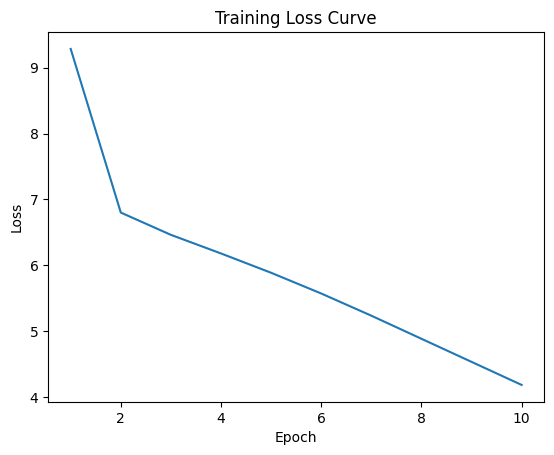

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


with open("Persian-WikiText-1.txt", "r", encoding="utf-8") as f:
    text = f.read()


tokens = text.split()
vocab = sorted(set(tokens))
token_to_idx = {token: idx for idx, token in enumerate(vocab)}
idx_to_token = {idx: token for token, idx in token_to_idx.items()}


data_indices = [token_to_idx[token] for token in tokens]


LIMIT = 10000  # Adjust the limit to your needs
data_indices = data_indices[:LIMIT]


class NGramDataset(Dataset):
    def __init__(self, data, context_size):
        self.data = data
        self.context_size = context_size

    def __len__(self):
        return len(self.data) - self.context_size

    def __getitem__(self, idx):
        context = self.data[idx:idx + self.context_size]
        target = self.data[idx + self.context_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Hyperparameters
context_size = 5
embedding_dim = 64
hidden_dim = 128
batch_size = 64
num_epochs = 10
learning_rate = 0.001


dataset = NGramDataset(data_indices, context_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class NGramRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, context_size):
        super(NGramRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        output = self.fc(rnn_out[:, -1, :])
        return output


vocab_size = len(vocab)
model = NGramRNN(vocab_size, embedding_dim, hidden_dim, context_size).to(device)  # Move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for contexts, targets in dataloader:
        contexts, targets = contexts.to(device), targets.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(contexts)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


torch.save(model.state_dict(), "ngram_rnn_model.pth")


#context_size = 5
#embedding_dim = 64
#hidden_dim = 128
#batch_size = 64
#num_epochs = 10
#learning_rate = 0.001

#Perplexity:

In [14]:
import torch
import torch.nn as nn
import math



def calculate_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)


            outputs = model(contexts)


            loss = nn.CrossEntropyLoss()(outputs, targets)
            total_loss += loss.item() * contexts.size(0)
            total_tokens += contexts.size(0) * contexts.size(1)


    avg_log_likelihood = total_loss / total_tokens

    perplexity = math.exp(avg_log_likelihood)
    return perplexity

perplexity = calculate_perplexity(model, dataloader, device)
print(f"Perplexity: {perplexity:.4f}")


Perplexity: 2.1148


In [18]:
import torch
from torch.nn import functional as F


model = NGramRNN(vocab_size, embedding_dim, hidden_dim, context_size).to('cuda')
model.load_state_dict(torch.load("ngram_rnn_model.pth"))
model.eval()


def custom_tokenizer(prompt):
    return prompt.split()


def generate_text(model, prompt, max_length=50, device='cuda'):
    model.eval()
    input_tokens = custom_tokenizer(prompt)
    input_ids = torch.tensor([token_to_idx[token] for token in input_tokens], dtype=torch.long).unsqueeze(0).to(device)  # Encode prompt as tensor

    generated_text = prompt

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(input_ids)
            logits = outputs
            next_token_id = torch.argmax(logits, dim=-1).item()

            next_token = idx_to_token[next_token_id]
            generated_text += " " + next_token


            input_ids = torch.cat([input_ids, torch.tensor([[next_token_id]], device=device)], dim=1)

    return generated_text

prompt = "امروز روز خوبی است"
generated_text = generate_text(model, prompt, max_length=10, device='cuda')
print("Generated Text: ", generated_text)


<ipython-input-18-c6fac7571911>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ngram_rnn_model.pth"))


Generated Text:  امروز روز خوبی است که در سال ۲۰۰۴ به کار می شود. در سال


#Transformers

In [ ]:
!pip install torch transformers tokenizers


#Prepare the Dataset for Training

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class PersianTextDataset(Dataset):
    def __init__(self, tokenizer, file_path, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length


        with open(file_path, 'r', encoding='utf-8') as file:
            self.text = file.read().split('.')


        self.encoded_texts = [
            tokenizer.encode(sentence).ids for sentence in self.text if sentence.strip()
        ]

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        encoded_text = self.encoded_texts[idx]
        input_ids = encoded_text[:self.max_length]
        padding_length = self.max_length - len(input_ids)


        input_ids += [self.tokenizer.token_to_id("<pad>")] * padding_length


        attention_mask = [1 if i != self.tokenizer.token_to_id("<pad>") else 0 for i in input_ids]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        }


dataset = PersianTextDataset(tokenizer, "cleaned_text.txt", max_length=128)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Define the Transformer Model

In [ ]:
import torch.nn as nn
import math

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, max_len=128):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, d_model))

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):

        embedded = self.embedding(input_ids) + self.positional_encoding[:, :input_ids.size(1), :]
        embedded = self.dropout(embedded)


        embedded = embedded.permute(1, 0, 2)  # [batch_size, seq_len, d_model] -> [seq_len, batch_size, d_model]
        mask = attention_mask == 0  # Mask for padding tokens
        transformer_output = self.transformer_encoder(embedded, src_key_padding_mask=mask)


        output = self.fc_out(transformer_output.permute(1, 0, 2))  # Back to [batch_size, seq_len, vocab_size]
        return output


#Train the Model

In [ ]:
from torch.optim import Adam
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Subset


debug_size = int(len(dataset) * 0.1)  # Use 10% of the dataset for debugging
debug_indices = list(range(debug_size))
debug_dataloader = torch.utils.data.DataLoader(
    Subset(dataset, debug_indices), batch_size=64, shuffle=True
)

# Model parameters
vocab_size = tokenizer.get_vocab_size()
d_model = 256
nhead = 8
num_layers = 4


model = Transformer(vocab_size, d_model, nhead, num_layers)
model = model.to(device)


optimizer = Adam(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id("<pad>"))


scaler = GradScaler()

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch in debug_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        with autocast():
            outputs = model(input_ids, attention_mask)
            logits = outputs.view(-1, vocab_size)
            targets = input_ids.view(-1)


            loss = loss_fn(logits, targets)


        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(debug_dataloader)}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-15-9defac12ba14>:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-15-9defac12ba14>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Epoch 1/10, Loss: 4.737224984169006
Epoch 2/10, Loss: 2.2871448152501817
Epoch 3/10, Loss: 1.4500436161605406
Epoch 4/10, Loss: 1.0141906413393962
Epoch 5/10, Loss: 0.7455249874524668
Epoch 6/10, Loss: 0.5643928113537775
Epoch 7/10, Loss: 0.43485227840047486
Epoch 8/10, Loss: 0.33793307672923717
Epoch 9/10, Loss: 0.26414077752073045
Epoch 10/10, Loss: 0.20745577879354987


# The loss has decreased

#Generate Text and save model

In [ ]:
import torch

torch.save(model.state_dict(), "persian_transformer.pth")


model.eval()
example_input = tokenizer.encode(" این یک نمونه تست است. حال").ids
example_input = torch.tensor(example_input).unsqueeze(0).to(device)
output = model(example_input, attention_mask=torch.ones_like(example_input).to(device))
predicted_ids = output.argmax(-1).squeeze().tolist()
predicted_text = tokenizer.decode(predicted_ids)

print("Generated text:", predicted_text)


Generated text: این یک نمونه تست است بروز حال


#Calculate Perplexity

In [ ]:
import torch
import math
from torch.utils.data import DataLoader


model = Transformer(vocab_size, d_model, nhead, num_layers)
model.load_state_dict(torch.load("persian_transformer.pth"))
model = model.to(device)


model.eval()

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id("<pad>"))

# Create a DataLoader for the validation data (if you have a validation dataset)
# If you don't have one, you can use a subset of the training dataset for evaluation
validation_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


total_loss = 0
total_samples = 0

with torch.no_grad():
    model.eval()
    for batch in validation_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)


        outputs = model(input_ids, attention_mask)
        logits = outputs.view(-1, vocab_size)
        targets = input_ids.view(-1)


        loss = loss_fn(logits, targets)

        total_loss += loss.item() * input_ids.size(0)
        total_samples += input_ids.size(0)


avg_loss = total_loss / total_samples
perplexity = math.exp(avg_loss)

print(f"Perplexity: {perplexity:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-17-cb7f6bed71e2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

Perplexity: 1.4010


#The perplexity has decreased